In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm
%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Aggregation and Group Operations

In [ ]:
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

## GroupBy Mechanics

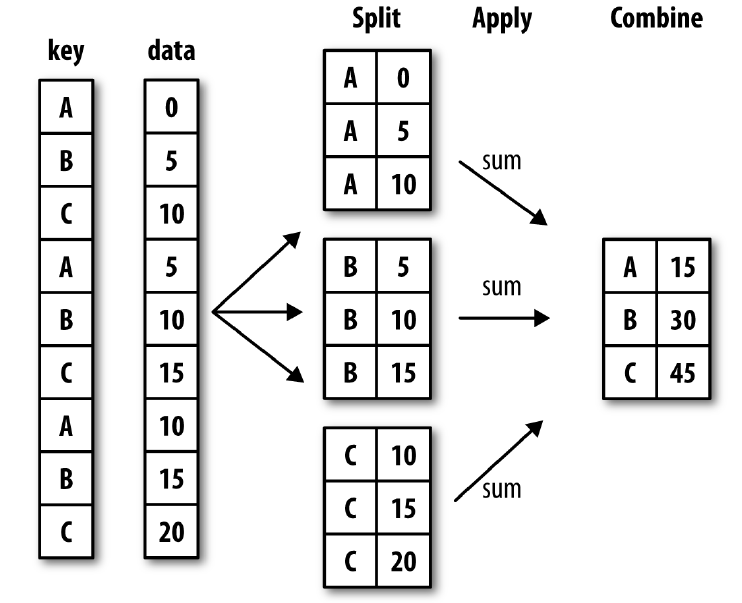

In [ ]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

In [ ]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [ ]:
grouped.mean()

In [ ]:
grouped.sum()

In [ ]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

In [ ]:
means.unstack()

In [ ]:
df.groupby('key1').mean()

In [ ]:
df.groupby(['key1', 'key2']).mean()

In [ ]:
df.groupby(['key1', 'key2']).size()

### Iterating Over Groups

In [ ]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

In [ ]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

In [ ]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

### Selecting a Column or Subset of Columns

In [ ]:
df.groupby(['key1', 'key2'])[['data2']].mean()

In [ ]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped.mean()

### Grouping with Functions

In [ ]:
people = pd.DataFrame(np.random.randn(5, 5),columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Ahmad', 'Sohail', 'Waseem', 'Umar', 'Hamza'])

In [ ]:
people

In [ ]:
people.groupby(len).sum()

## Data Aggregation

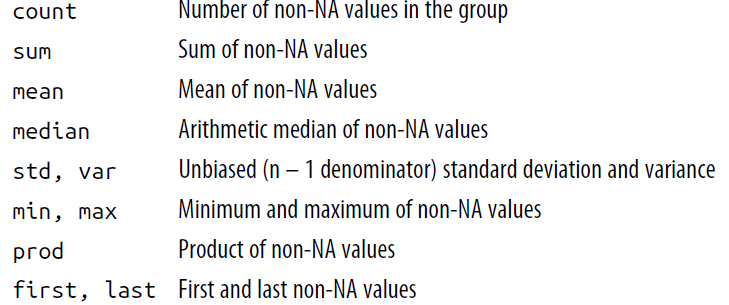

In [ ]:
df
grouped = df.groupby('key1')

In [ ]:
grouped['data1'].quantile(0.9)

In [ ]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

In [ ]:
grouped.describe()

### Column-Wise and Multiple Function Application

In [ ]:
tips = pd.read_csv('data/tips.csv')

In [ ]:
tips.head()

In [ ]:
grouped = tips.groupby(['day', 'smoker'])

In [ ]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [ ]:
grouped_pct = grouped['tip_pct']

In [ ]:
grouped_pct.agg('mean')

In [ ]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

In [ ]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

In [ ]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

In [ ]:
result['tip_pct']

### Returning Aggregated Data Without Row Indexes

In [ ]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

## Apply: General split-apply-combine

In [ ]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

In [ ]:
tips.groupby('smoker').apply(top)

In [ ]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

### Suppressing the Group Keys

In [ ]:
tips.groupby('smoker', group_keys=False).apply(top)

### Quantile and Bucket Analysis

In [ ]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(quartiles)
result = grouped.apply(get_stats)

In [ ]:
result

In [ ]:
result.unstack()

In [ ]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

### Example: Filling Missing Values with Group-Specific       Values

In [ ]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s
s.fillna(s.mean())

In [ ]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

In [ ]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

In [ ]:
data.groupby(group_key).mean()

In [ ]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

In [ ]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

### Example: Group Weighted Average and Correlation

In [ ]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

In [ ]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

In [ ]:
close_px = pd.read_csv('data/stock_px_2.csv', parse_dates=True,
                       index_col=0)

In [ ]:
close_px.head()

In [ ]:
close_px.tail()

In [ ]:
spx_corr = lambda x: x.corrwith(x['SPX'])

In [ ]:
rets = close_px.pct_change().dropna()

In [ ]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

In [ ]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))